In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import pickle
import numpy as np
from tqdm import tqdm
from jax import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file('../matplotlibrc')

In [2]:
def get_rec(rn):
    return np.load(f"../outputs/dm21cm/{rn}_records.npy", allow_pickle=True).item()

## Slices

In [3]:
def plot_silces_multi_runs(
        r_s, i_s, k,
        plot_log=True, save_fn=None, titles=None,
        shift_mean=None, plot_delta=False, individual_cbar=False,
        plot_change_i_s=None,
    ):

    if isinstance(i_s, int):
        i_s = np.full(len(r_s), i_s)

    plot_n = len(r_s)
    if plot_delta:
        plot_n += 1

    fig, axs = plt.subplots(1, plot_n, figsize=(6*plot_n, 7))
    if plot_n == 1:
        axs = [axs]

    if plot_change_i_s is not None:
        z_s = [r[k][i] - r[k][i-c_i] for i, r, c_i in zip(i_s, r_s, plot_change_i_s)]
    else:
        z_s = [r[k][i] for i, r in zip(i_s, r_s)]
    if k == 'x_H_slice':
        z_s = [1-z for z in z_s]
    z_mean_s = [np.mean(z) for z in z_s]
    if shift_mean is not None:
        if shift_mean == '+':
            z_s = [z-z_mean_s[i_plot] for i_plot, z in enumerate(z_s)]
        else:
            z_s = [z/z_mean_s[i_plot] for i_plot, z in enumerate(z_s)]
    if plot_log:
        z_s = [np.log10(z) for z in z_s]
    vmin = np.quantile(np.concatenate(z_s), 0.02)
    vmax = np.quantile(np.concatenate(z_s), 0.98)

    for i_plot in range(len(r_s)):
        ax = axs[i_plot]
        if individual_cbar:
            im = ax.imshow(z_s[i_plot], origin='lower')
            fig.colorbar(im, ax=ax, orientation='horizontal')
        else:
            im = ax.imshow(z_s[i_plot], origin='lower', vmin=vmin, vmax=vmax)
        title = titles[i_plot] if titles is not None else ''
        ax.set_title(f"{title} mean={z_mean_s[i_plot]:.3e}")

    k_title = k if k != 'x_H_slice' else '1-x_H_slice'
    if plot_change_i_s is not None:
        k_title = r"$\Delta$" + k_title
    fig.suptitle(f"{k_title}, $z$={r_s[0]['z'][i_s[0]]:.3f}")
    if not individual_cbar:
        fig.colorbar(im, ax=axs[:len(r_s)], orientation='horizontal', aspect=len(r_s)*20)
    if plot_delta:
        ax = axs[-1]
        im_delta = ax.imshow(r_s[0]['delta_slice'][i_s[0]], origin='lower', cmap='viridis')
        ax.set_title('delta')
        fig.colorbar(im_delta, ax=axs[-1], orientation='horizontal', aspect=20)

    if save_fn is not None:
        fig.savefig(save_fn)
        plt.close(fig)

In [37]:
run_names = [
    # 'sf_xunifx100_nodplus1_nopop2',
    # 'sf_xunifx100_nodplus1_dc_noLX_nopop2_uddn',
    # 'sf_xdecayx100_nodplus1_nopop2',
    # 'sf_xdecayx100_nodplus1_nopop2_uddn_test',
    # 'sf_xdecayx100_nodplus1_dc_noLX_nopop2_uddn',
    # 'sf_xdecayx100_nodplus1_dc_noLX_nopop2_uddn_01atten',
    # 'sf_xdecayx100_dc_noLX_nodplus1_nopop2_uddn_xrayots',
    # 'sf_xdecayx100_dc_noLX_nodplus1_nopop2_uddn_xrayots_cut500',
    
    # 'sf_xdecayx100_nodplus1_nopop2_zf001_Rmax32',
    # 'sf_xdecayx100_nodplus1_dc_noLX_nopop2_uddn_zf001_Rmax32',
    # 'sf_xdecayx100_nodplus1_dc_noLX_nopop2_uddn_xrayots_cut500_zf001',
    # 'sf_xdecayx100_nodplus1_dc_noLX_nopop2_uddn_xraybath_cut500_zf001',
    
    # 'sf_xdecayx10_nodplus1_noxesink_nopop2_zf001',
    # 'sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_uddn_01atten_bath_ots_zf001',

    # 'sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_uddn_01atten_ots', # just to make sure I understand bath
    # 'sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_uddn_01atten_bath_ots',

    #--- All dep to ion ---
    'sf_xdecayx10_nodplus1_noxesink_nopop2_alldepion_zf001',
    #'sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_alldepion_uddn_01atten_bath_ots_zf001',
    'sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_alldepion_uddn_01atten_ots_adashell40_zf001',

    #--- All dep to ion zf01 ---
    # 'sf_xdecayx10_nodplus1_noxesink_nopop2_alldepion',
    # 'sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_alldepion_uddn_01atten_bath32_ots',
    # 'sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_alldepion_uddn_01atten_bath64_ots',
    # 'sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_alldepion_uddn_01atten_bath128_ots',
    # 'sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_alldepion_uddn_01atten_bath500_ots',
    # 'sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_alldepion_uddn_01atten_ots_adashell15',
]
r_s = [np.load(f"../outputs/dm21cm/{rn}_records.npy", allow_pickle=True).item() for rn in run_names]
#titles = ['21cmFAST', 'DM21cm', '21cmFAST', 'DM21cm', 'DM21cm']
titles = run_names

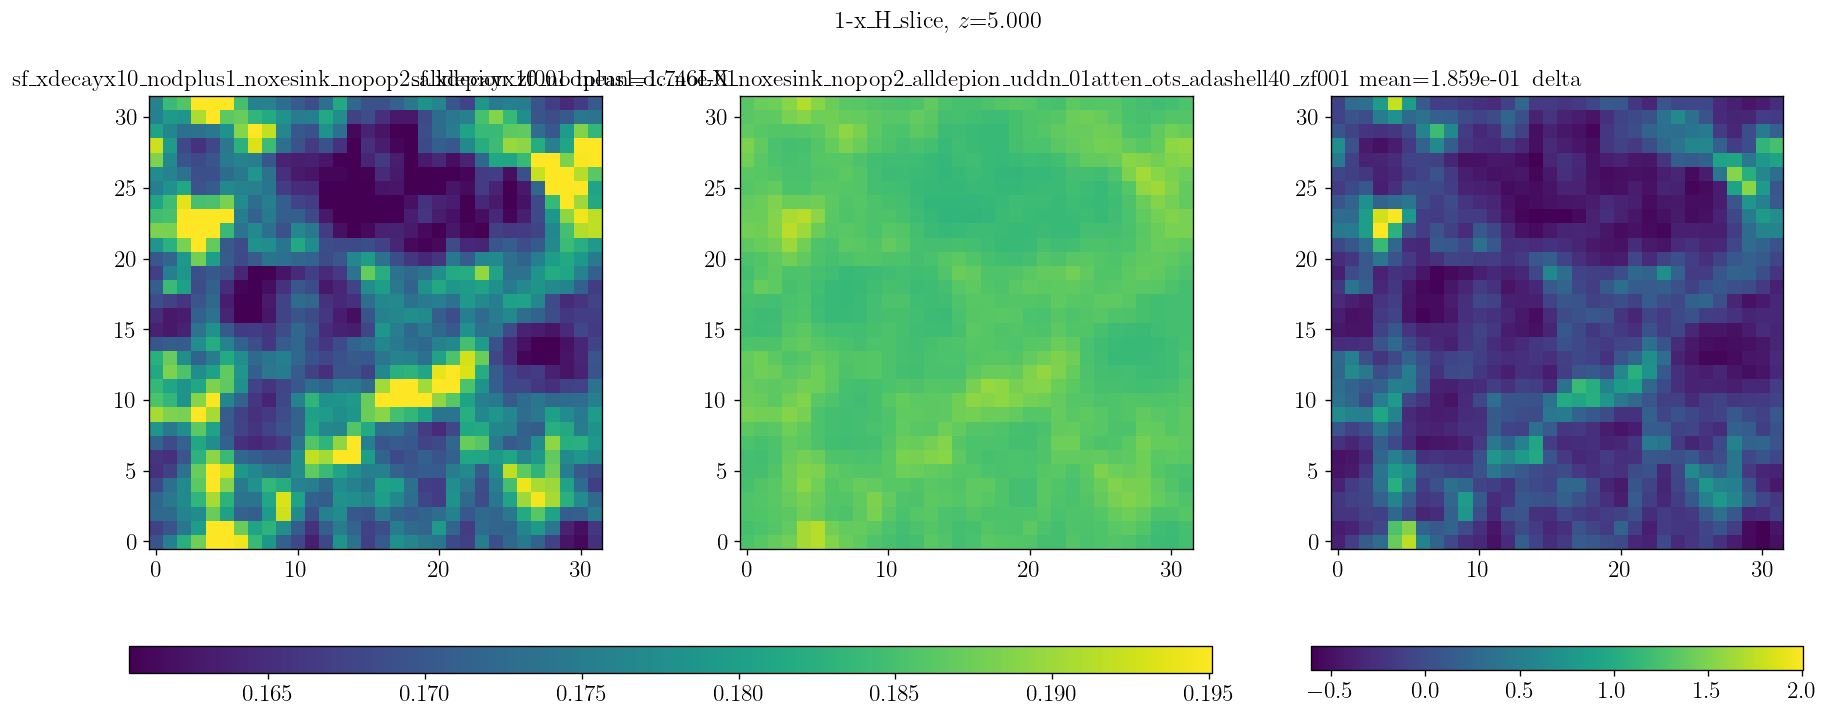

In [38]:
plot_silces_multi_runs(r_s, -1, 'x_H_slice', titles=titles, plot_delta=True, plot_log=False)

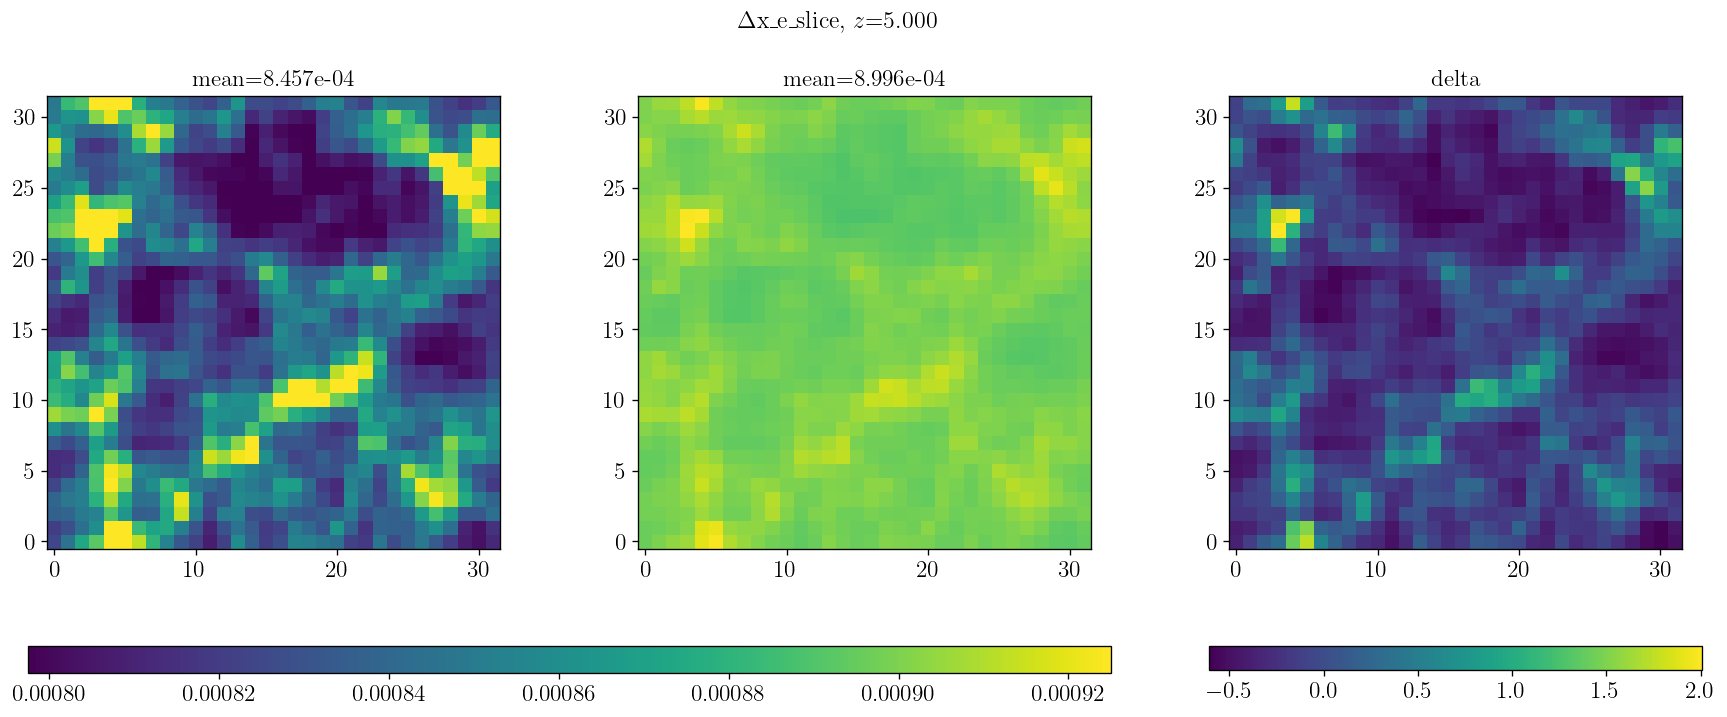

In [39]:
plot_silces_multi_runs(r_s, -1, 'x_e_slice',
                       titles=['', ''], plot_delta=True, plot_log=False, plot_change_i_s=[1, 1])

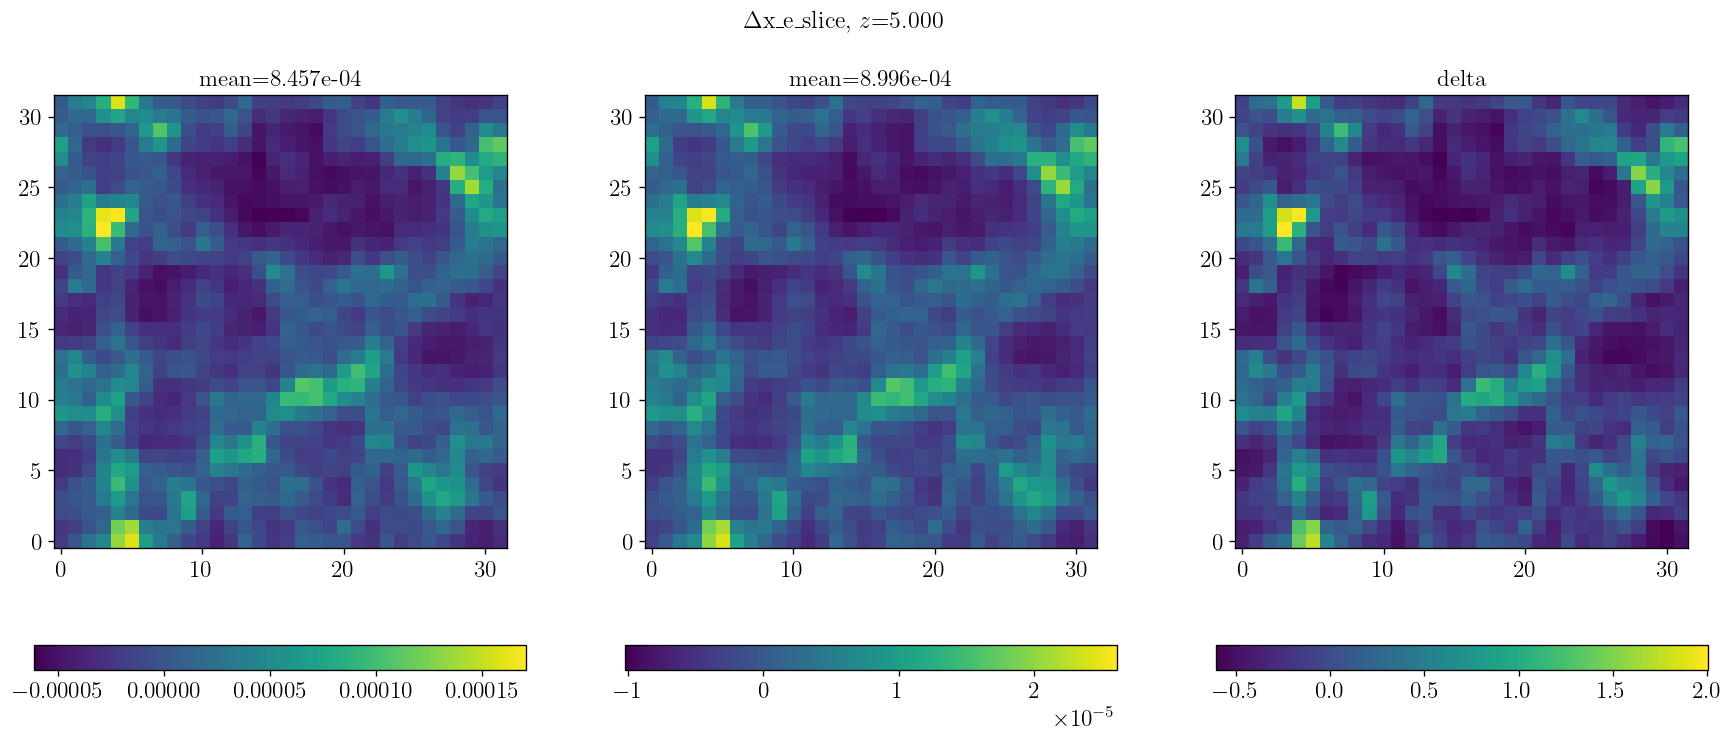

In [40]:
plot_silces_multi_runs(r_s, -1, 'x_e_slice',
                       titles=['', ''], plot_delta=True, plot_log=False, plot_change_i_s=[1, 1], individual_cbar=True, shift_mean='+')

In [42]:
# dc
rec_dc = get_rec('sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_alldepion_uddn_01atten_ots_adashell40_zf001')
dxe_dc = rec_dc['x_e_slice'][-1] - rec_dc['x_e_slice'][-2]

# pc
rec_pc = get_rec('sf_xdecayx10_nodplus1_noxesink_nopop2_alldepion_zf001')
dxe_pc = rec_pc['x_e_slice'][-1] - rec_pc['x_e_slice'][-2]

In [44]:
print(np.std(dxe_dc), np.mean(dxe_dc), np.std(dxe_dc)/np.mean(dxe_dc))
print(np.std(dxe_pc), np.mean(dxe_pc), np.std(dxe_pc)/np.mean(dxe_pc))

5.538167e-06 0.00089956215 0.006156514
3.630646e-05 0.0008457381 0.04292873


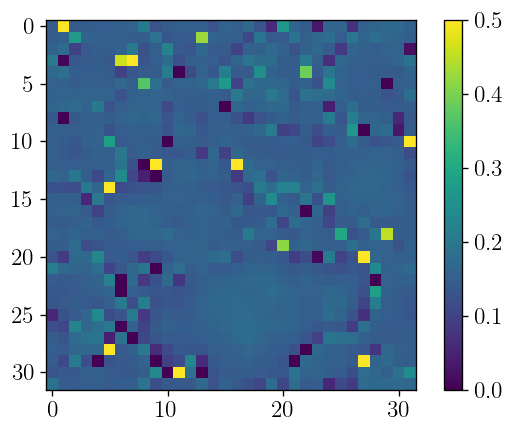

In [45]:
z1 = dxe_dc-np.mean(dxe_dc)
z2 = dxe_pc-np.mean(dxe_pc)
plt.imshow(z1/z2, vmin=0, vmax=0.5)
plt.colorbar()

In [14]:
sys.path.append("..")
import h5py
from dm21cm.evolve import get_z_edges, get_emissivity_bracket
import dm21cm.physics as phys
from dm21cm.utils import load_h5_dict
from scipy import interpolate
from dm21cm.dh_wrappers import TransferFunctionWrapper
import jax.numpy as jnp
from astropy.cosmology import Planck18
from dm21cm.data_cacher import Cacher
from astropy import units as u
from darkhistory.spec.spectrum import Spectrum

In [15]:
z_edges = get_z_edges(45, 5, 1.001)[1:]

In [16]:
# let's try to reproduce the second panel
rn_dc = "sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_alldepion_uddn_01atten_ots_adashell40_zf001"
cache_dir = os.environ['P21C_CACHE_DIR'] + f"/{rn_dc}"
with h5py.File(f"{cache_dir}/xraycheck_brightness.h5", 'r') as hf:
    delta = hf['Box_2036'][()]

In [17]:
rec2 = np.load(f"../outputs/dm21cm/{rn_dc}_2_records_extra.npy", allow_pickle=True).item()

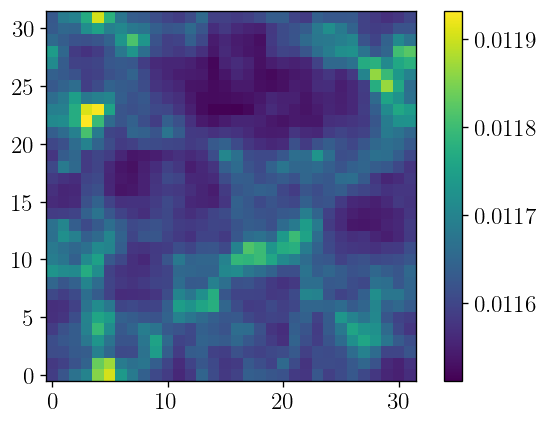

In [18]:
plt.imshow(np.sum(rec2['dep_box'][-1], axis=-1)[0], origin='lower')
plt.colorbar();

In [19]:
z = np.sum(rec2['dep_box'][-1], axis=-1)[0]
print(np.std(z)/np.mean(z), np.mean(z))

0.005440204782158525 0.011622862946541196


In [20]:
x_e_box = rec2['x_e_box'][-1]

In [21]:
data_dir = os.environ['DM21CM_DATA_DIR'] + f"/tf/zf001/data" # check zf01
sfrd_tables = load_h5_dict(f"{data_dir}/sfrd_tables.h5")
z_range = sfrd_tables['z_range']
delta_range = sfrd_tables['delta_range']
r_range = sfrd_tables['r_range']
cond_sfrd_table = sfrd_tables['cond_sfrd_table']
st_sfrd_table = sfrd_tables['st_sfrd_table']

st_multiplier = 10.
# Takes the redshift as `z`
# Returns the mean ST star formation rate density star formation rate density in [M_Sun / Mpc^3 / s]
ST_SFRD_Interpolator = interpolate.interp1d(z_range, st_sfrd_table * st_multiplier)

In [22]:
abscs = load_h5_dict(f"{data_dir}/abscissas.h5")
tf_wrapper = TransferFunctionWrapper(
    box_dim = 32,
    abscs = abscs,
    prefix = data_dir,
    enable_elec = False,
    on_device = True,
)

INFO:root:TransferFunctionWrapper: Loaded photon transfer functions.


In [23]:
spec_cache = pickle.load(open(f"{cache_dir}/spec_cache.p", 'rb'))

In [24]:
delta_cacher = Cacher(
    data_path="tmp.h5",
    cosmo=Planck18, N=32, dx=2.,
    shell_Rmax=500.,
    Rmax=500.,
)

In [25]:
i_shell_chosen = [2036, 2035, 2034, 2033, 2032, 2031, 2030, 2029, 2028, 2027, 2026, 2025, 2024, 2023,
                  2021, 2020, 2018, 2016, 2014, 2012, 2009, 2006, 2003, 2000, 1996, 1992, 1987, 1982,
                  1977, 1971, 1964, 1957, 1948, 1939, 1929, 1918, 1906, 1892, 1877, 1861]

In [26]:
z_current = z_edges[2036]

tf_wrapper.init_step(
    rs = 1 + z_current,
    delta_plus_one_box = jnp.ones((32, 32, 32)),
    x_e_box = x_e_box,
)
dt = phys.dt_step(z_current, np.exp(abscs['dlnz']))

R_arr = []
dep_ion_arr = []

accumulated_N = np.zeros((500,))

for i_z_shell in range(1861, 2037):
    z_shell = z_edges[i_z_shell]
    R2 = phys.conformal_dx_between_z(z_shell, z_current)

    L_X_spec = spec_cache.get_spectrum(z_shell)
    
    cond_sfrd = lambda z, d, r: 1.+d
    emissivity_bracket = get_emissivity_bracket(
        z=z_shell, delta=0., R=R2, dt=dt,
        debug_nodplus1=True, cond_sfrd=cond_sfrd, st_sfrd=ST_SFRD_Interpolator,
    ) # [Msun / Bavg]
    accumulated_N += L_X_spec.N * emissivity_bracket

    if i_z_shell not in i_shell_chosen:
        continue
    
    with h5py.File(f"{cache_dir}/xraycheck_brightness.h5", 'r') as hf:
        delta = hf['Box_'+str(i_z_shell)][()]
    #delta = jnp.fft.irfftn(delta)
    
    delta_smoothed, _ = delta_cacher.smooth_box(delta, 1e-10, R2)

    print(f"{i_z_shell}, {z_shell:.3f}, {np.std(1+delta_smoothed) / np.mean(1+delta_smoothed):.6f}, {np.mean(1+delta_smoothed):.6f}")

    #L_X_spec = spec_cache.get_spectrum(z_shell)
    
    cond_sfrd = lambda z, d, r: 1.+d
    emissivity_bracket = get_emissivity_bracket(
        z=z_shell, delta=delta_smoothed, R=R2, dt=dt,
        debug_nodplus1=True, cond_sfrd=cond_sfrd, st_sfrd=ST_SFRD_Interpolator,
    ) # [Msun / Bavg]
    emissivity_bracket /= np.mean(emissivity_bracket)

    dep_ion_mean_before = np.mean(tf_wrapper.dep_box[...,0]+tf_wrapper.dep_box[...,1])
    tf_wrapper.inject_phot(L_X_spec, inject_type='xray', weight_box=jnp.asarray(emissivity_bracket))
    dep_ion = np.mean(tf_wrapper.dep_box[...,0]+tf_wrapper.dep_box[...,1]) - dep_ion_mean_before

    accumulated_N *= 0.

    R_arr.append(R2)
    dep_ion_arr.append(dep_ion)

R_arr = np.array(R_arr)
dep_ion_arr = np.array(dep_ion_arr)

# OTS
OTS = False
if OTS:
    with h5py.File(f"{cache_dir}/xraycheck_brightness.h5", 'r') as hf:
        delta = hf['Box_2036'][()]
    z_donor = z_current
    delta = np.fft.irfftn(delta)
    R2 = 0.

    xray_eng_lo = 0.5 * 1000 # [eV]
    xray_eng_hi = 10.0 * 1000 # [eV]
    xray_i_lo = np.searchsorted(abscs['photE'], xray_eng_lo)
    xray_i_hi = np.searchsorted(abscs['photE'], xray_eng_hi)
    L_X_numerical_factor = 1e60 # make float happy

    L_X_spec_prefac = 1e40 / np.log(4) * u.erg * u.s**-1 * u.M_sun**-1 * u.yr * u.keV**-1 # value in [erg yr / s Msun keV]
    L_X_spec_prefac /= L_X_numerical_factor
    # L_X (E * dN/dE) \propto E^-1
    L_X_dNdE = L_X_spec_prefac.to('1/Msun').value * (abscs['photE']/1000.)**-1 / abscs['photE'] # [1/Msun] * [1/eV] = [1/Msun eV]
    L_X_dNdE[:xray_i_lo] *= 0.
    L_X_dNdE[xray_i_hi:] *= 0.
    L_X_spec = Spectrum(abscs['photE'], L_X_dNdE, spec_type='dNdE', rs=1+z_current) # [1 / Msun eV]
    L_X_spec.switch_spec_type('N') # [1 / Msun]

    cond_sfrd = lambda z, d, r: 1.+d
    emissivity_bracket = get_emissivity_bracket(
        z=z_donor, delta=delta, R=R2, dt=dt,
        debug_nodplus1=True, cond_sfrd=cond_sfrd, st_sfrd=ST_SFRD_Interpolator,
    ) # [Msun / Bavg]

    tf_wrapper.inject_phot(L_X_spec, inject_type='xray', weight_box=jnp.asarray(emissivity_bracket))

1861, 6.154, 0.000000, 1.000000
1877, 6.041, 0.000061, 1.000000
1892, 5.936, 0.000103, 1.000000
1906, 5.839, 0.000120, 1.000000
1918, 5.758, 0.000082, 1.000000
1929, 5.684, 0.000144, 1.000000
1939, 5.617, 0.000066, 1.000000
1948, 5.558, 0.000199, 1.000000
1957, 5.499, 0.000346, 1.000000
1964, 5.454, 0.000419, 1.000000
1971, 5.409, 0.000389, 1.000000
1977, 5.371, 0.000554, 1.000000
1982, 5.339, 0.000392, 1.000000
1987, 5.307, 0.000973, 1.000000
1992, 5.276, 0.000770, 1.000000
1996, 5.251, 0.001295, 1.000000
2000, 5.226, 0.001457, 1.000000
2003, 5.207, 0.001324, 1.000000
2006, 5.189, 0.002332, 1.000000
2009, 5.170, 0.002779, 1.000000
2012, 5.152, 0.001615, 1.000000
2014, 5.140, 0.004259, 1.000000
2016, 5.127, 0.005807, 1.000000
2018, 5.115, 0.005558, 1.000000
2020, 5.103, 0.005860, 1.000000
2021, 5.097, 0.007096, 1.000000
2023, 5.085, 0.011285, 1.000000
2024, 5.078, 0.012868, 1.000000
2025, 5.072, 0.014486, 1.000000
2026, 5.066, 0.018156, 1.000000
2027, 5.060, 0.025262, 1.000000
2028, 5.

0.037333443377962384 0.030359858632882805


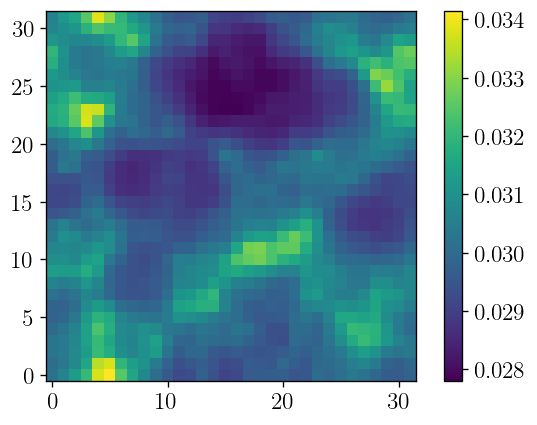

In [27]:
dep_ion_box = np.sum(tf_wrapper.dep_box[...,:4], axis=-1)
plt.imshow(dep_ion_box[0], origin='lower', cmap='viridis')
plt.colorbar()
print(np.std(dep_ion_box)/np.mean(dep_ion_box), np.mean(dep_ion_box))

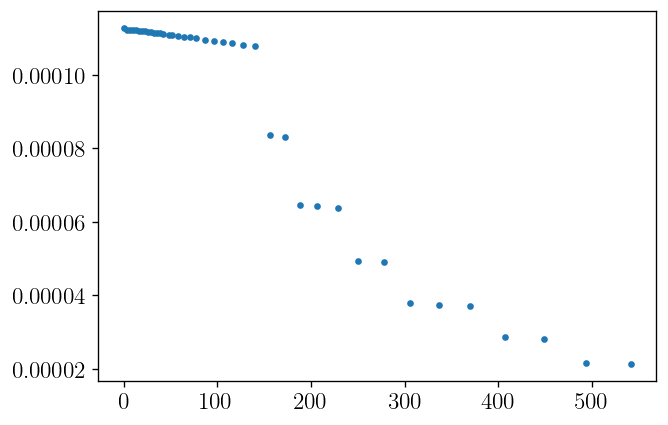

In [72]:
plt.plot(R_arr, dep_ion_arr, '.')

In [ ]:
dlogR = np.diff(-np.log10(R_arr))
plt.plot(R_arr[:-1], dep_ion_arr[:-1]/dlogR, '-s')
plt.xscale('log')

## in comparison, what is the main code doing?

In [72]:
from dm21cm.evolve import geom_inds, custom_SFRD, debug_get_21totf_interp
from dm21cm.spectrum import AttenuatedSpectrum

In [73]:
z_edges = get_z_edges(45, 5, 1.001)[1:]

delta_cacher_recon = Cacher(
    data_path="xraycheck_brightness.h5",
    cosmo=Planck18, N=32, dx=2.,
    shell_Rmax=500.,
    Rmax=500.,
)
delta_cacher_recon.brightness_cache.z_s = z_edges[:-1]
delta_cacher_recon.spectrum_cache = pickle.load(open(f"{cache_dir}/spec_cache.p", 'rb'))

In [74]:
i_z = 2036
z_current = z_edges[i_z]
i_xraycheck_shell_start = 1861 # CHECK LATER!!!
adaptive_shell = 40
debug_flags = ['xc-01attenuation', 'xc-custom-SFRD']
debug_nodplus1 = True
EPSILON = 1e-6
debug_use_21_totinj = "../scripts/sf_xdecayx10_nodplus1_noxesink_nopop2_alldepion_zf001.out"
ref_interp = debug_get_21totf_interp(debug_use_21_totinj)
xray_eng_lo = 0.5 * 1000 # [eV]
xray_eng_hi = 10.0 * 1000 # [eV]
xray_i_lo = np.searchsorted(abscs['photE'], xray_eng_lo)
xray_i_hi = np.searchsorted(abscs['photE'], xray_eng_hi)
L_X_numerical_factor = 1e60 # make float happy

tf_wrapper.init_step(
    rs = 1 + z_current,
    delta_plus_one_box = jnp.ones((32, 32, 32)),
    x_e_box = x_e_box,
)

i_max = i_z - i_xraycheck_shell_start
inds_increasing = geom_inds(i_max=i_max, i_transition=10, n_goal=adaptive_shell)
inds_shell = i_z - inds_increasing
print('adaptive shell:', inds_shell, flush=True)

accumulated_shell_N = np.zeros_like(abscs['photE']) # [ph / Bavg]

for i_z_shell in range(i_xraycheck_shell_start, i_z):

    z_shell = z_edges[i_z_shell]

    #--- for all shells ---
    shell_N = np.array(delta_cacher_recon.spectrum_cache.get_spectrum(z_shell).N) # [ph / Msun]
    if 'xc-custom-SFRD' in debug_flags:
        cond_sfrd = custom_SFRD
    else:
        raise NotImplementedError
    emissivity_bracket = get_emissivity_bracket(
        z=z_shell, delta=0., R=phys.conformal_dx_between_z(z_shell, z_current), dt=dt,
        debug_nodplus1=debug_nodplus1, cond_sfrd=cond_sfrd, st_sfrd=ST_SFRD_Interpolator,
    ) # [Msun / Bavg] # get average

    accumulated_shell_N += shell_N * emissivity_bracket # [ph / Bavg]
    if i_z_shell not in inds_shell:
        continue

    #--- now, the chosen ones ---
    delta, L_X_spec, xraycheck_is_box_average, z_donor, R2 = delta_cacher_recon.get_annulus_data(
        z_current, z_edges[i_z_shell], z_edges[i_z_shell+1]
    )
    print(f"{i_z_shell}, {z_shell:.3f}, {np.std(1+delta) / np.mean(1+delta):.6f}, {np.mean(1+delta):.6f}")
    
    if 'xc-custom-SFRD' in debug_flags:
        delta = jnp.array(delta)
        cond_sfrd = custom_SFRD
    else:
        raise NotImplementedError
    emissivity_bracket = get_emissivity_bracket(
        z=z_donor, delta=delta, R=R2, dt=dt,
        debug_nodplus1=debug_nodplus1, cond_sfrd=cond_sfrd, st_sfrd=ST_SFRD_Interpolator,
    ) # [Msun / Bavg]
    # use averaged spectrum: this step already counted
    if np.mean(emissivity_bracket) != 0.:
        emissivity_bracket /= np.mean(emissivity_bracket)

    #dep_tracker.reset(tf_wrapper.dep_box)
    if np.mean(emissivity_bracket) != 0.:
        inj_spec = Spectrum(abscs['photE'], accumulated_shell_N, spec_type='N', rs=1+z_current) # [ph / Bavg]
        tf_wrapper.inject_phot(inj_spec, inject_type='xray', weight_box=jnp.asarray(emissivity_bracket))
    #dep_tracker.record(tf_wrapper.dep_box, R=phys.conformal_dx_between_z(z_shell, z_current), from_bath=False)

    accumulated_shell_N *= 0. # clear after injection

    if xraycheck_is_box_average:
        i_xraycheck_shell_start = max(i_z_shell+1, i_xraycheck_shell_start)

#----- new shell can deposits as well! -----
# x_e_for_attenuation = 1 - np.mean(ionized_box.xH_box)
# attenuation_arr = np.array(tf_wrapper.attenuation_arr(rs=1+z_current, x=x_e_for_attenuation)) # convert from jax array
# if 'xc-noatten' in debug_flags: # TMP: turn off attenuation
#     attenuation_arr = np.ones_like(attenuation_arr)
# delta_cacher.advance_spectrum(attenuation_arr, z_next) # can handle AttenuatedSpectrum

L_X_spec_prefac = 1e40 / np.log(4) * u.erg * u.s**-1 * u.M_sun**-1 * u.yr * u.keV**-1 # value in [erg yr / s Msun keV]
L_X_spec_prefac /= L_X_numerical_factor
# L_X (E * dN/dE) \propto E^-1
L_X_dNdE = L_X_spec_prefac.to('1/Msun').value * (abscs['photE']/1000.)**-1 / abscs['photE'] # [1/Msun] * [1/eV] = [1/Msun eV]
L_X_dNdE[:xray_i_lo] *= 0.
L_X_dNdE[xray_i_hi:] *= 0.
L_X_spec = Spectrum(abscs['photE'], L_X_dNdE, spec_type='dNdE', rs=1+z_current) # [1 / Msun eV]
L_X_spec.switch_spec_type('N') # [1 / Msun]

z_next = z_edges[i_z+1]

L_X_spec.redshift(1+z_next)
if 'xc-01attenuation' in debug_flags:
    L_X_spec = AttenuatedSpectrum(L_X_spec)

if 'xc-ots' in debug_flags: # before saving, first ots injection
    
    z_donor = z_current
    with h5py.File(f"{cache_dir}/xraycheck_brightness.h5", 'r') as hf:
        delta = hf['Box_2036'][()]
    delta = np.fft.irfftn(delta)
    R2 = 0.

    if 'xc-custom-SFRD' in debug_flags:
        delta = jnp.array(delta)
        cond_sfrd = custom_SFRD
    else:
        raise NotImplementedError
    emissivity_bracket = get_emissivity_bracket(
        z=z_donor, delta=delta, R=R2, dt = dt,
        debug_nodplus1=debug_nodplus1, cond_sfrd=cond_sfrd, st_sfrd=ST_SFRD_Interpolator,
    ) # [Msun / Bavg]
    
    #dep_tracker.reset(tf_wrapper.dep_box)
    if np.mean(emissivity_bracket) != 0.:
        tf_wrapper.inject_phot(L_X_spec, inject_type='xray', weight_box=jnp.asarray(emissivity_bracket))
    #dep_tracker.record(tf_wrapper.dep_box, R=R2, from_bath=False)

    # if isinstance(L_X_spec, AttenuatedSpectrum):
    #     L_X_spec.attenuate(attenuation_arr)
    # else:
    #     L_X_spec.N *= attenuation_arr

    #----- after possible ots deposition, advance and save -----
    #delta_cacher.cache(z_current, jnp.array(perturbed_field.density), L_X_spec)

#===== 21cmFAST step =====
# perturbed_field = p21c.perturb_field(redshift=z_next, init_boxes=p21c_initial_conditions)
# input_heating, input_ionization, input_jalpha = gen_injection_boxes(z_next, p21c_initial_conditions)
class DummyBox:
    def __init__(self, N):
        self.N = N
        self.input_heating = np.zeros((N, N, N))
        self.input_ionization = np.zeros((N, N, N))
        self.input_jalpha = np.zeros((N, N, N))
input_heating = DummyBox(32)
input_ionization = DummyBox(32)
input_jalpha = DummyBox(32)

if debug_use_21_totinj is not None:
    ref_depE_per_B = ref_interp(z_current) * phys.A_per_B
else:
    ref_depE_per_B = None
# tf_wrapper.populate_injection_boxes(
#     input_heating, input_ionization, input_jalpha, dt,
#     debug_even_split_f=False,
#     ref_depE_per_B=ref_depE_per_B,
#     debug_z = z_current,
#     debug_unif_delta_dep = True,
#     debug_depallion = True,
# )

adaptive shell: [2036 2035 2034 2033 2032 2031 2030 2029 2028 2027 2026 2025 2024 2023
 2021 2020 2018 2016 2014 2012 2009 2006 2003 2000 1996 1992 1987 1982
 1977 1971 1964 1957 1948 1939 1929 1918 1906 1892 1877 1861]


1861, 6.154, 0.000000, 1.000000
1877, 6.041, 0.000009, 1.000000
1892, 5.936, 0.000016, 1.000000
1906, 5.839, 0.000018, 1.000000
1918, 5.758, 0.000012, 1.000000
1929, 5.684, 0.000021, 1.000000
1939, 5.617, 0.000010, 1.000000
1948, 5.558, 0.000029, 1.000000
1957, 5.499, 0.000049, 1.000000
1964, 5.454, 0.000059, 1.000000
1971, 5.409, 0.000055, 1.000000
1977, 5.371, 0.000078, 1.000000
1982, 5.339, 0.000054, 1.000000
1987, 5.307, 0.000135, 1.000000
1992, 5.276, 0.000106, 1.000000
1996, 5.251, 0.000178, 1.000000
2000, 5.226, 0.000200, 1.000000
2003, 5.207, 0.000181, 1.000000
2006, 5.189, 0.000318, 1.000000
2009, 5.170, 0.000378, 1.000000
2012, 5.152, 0.000220, 1.000000
2014, 5.140, 0.000577, 1.000000
2016, 5.127, 0.000783, 1.000000
2018, 5.115, 0.000748, 1.000000
2020, 5.103, 0.000790, 1.000000
2021, 5.097, 0.000954, 1.000000
2023, 5.085, 0.001514, 1.000000
2024, 5.078, 0.001726, 1.000000
2025, 5.072, 0.001942, 1.000000
2026, 5.066, 0.002426, 1.000000
2027, 5.060, 0.003362, 1.000000
2028, 5.

In [85]:
# z_shell = z_edges[2026]
# z_current = z_edges[2036]
# R2 = phys.conformal_dx_between_z(z_shell, z_current)

# L_X_spec = spec_cache.get_spectrum(z_shell)

# cond_sfrd = lambda z, d, r: 1.+d
# emissivity_bracket = get_emissivity_bracket(
#     z=z_shell, delta=0., R=R2, dt=dt,
#     debug_nodplus1=True, cond_sfrd=cond_sfrd, st_sfrd=ST_SFRD_Interpolator,
# ) # [Msun / Bavg]
# accumulated_N += L_X_spec.N * emissivity_bracket



0.018156012193868924


In [91]:
def get_box(self, z):
        """Returns the brightness box and spectrum at the specified cached state."""

	    # Get the index of the donor box
        box_index = np.argmin(np.abs(self.z_s - z))

        with h5py.File(self.data_path, 'r') as archive:
            box = jnp.array(archive['Box_' + str(box_index)], dtype=jnp.complex64)
        
        return boxR2

32.21362256654285

In [96]:
# def get_box(self, z):
#     """Returns the brightness box and spectrum at the specified cached state."""

#     # Get the index of the donor box
#     box_index = np.argmin(np.abs(self.z_s - z))

#     with h5py.File(self.data_path, 'r') as archive:
#         box = jnp.array(archive['Box_' + str(box_index)], dtype=jnp.complex64)
    
#     return box

box = delta_cacher_recon.brightness_cache.get_box(z_edges[2026])

sb, _ = delta_cacher_recon.smooth_box(box, 1e-10, 32.21362256654285)

print(np.std(sb+1)/np.mean(sb+1))

0.018156012193868924


In [95]:
with h5py.File(f"xraycheck_brightness.h5", 'r') as hf:
    delta = jnp.array(hf['Box_2026'][()], dtype=jnp.complex64)

sb, _ = delta_cacher_recon.smooth_box(delta, 1e-10, 32.21362256654285)

print(np.std(sb+1)/np.mean(sb+1))

0.018156012193868924


0.04292873 0.0008457381
0.006156514 0.00089956215
0.03787293907174878 0.0008919587803147092
0.005611799348412492 0.0008996285272376169


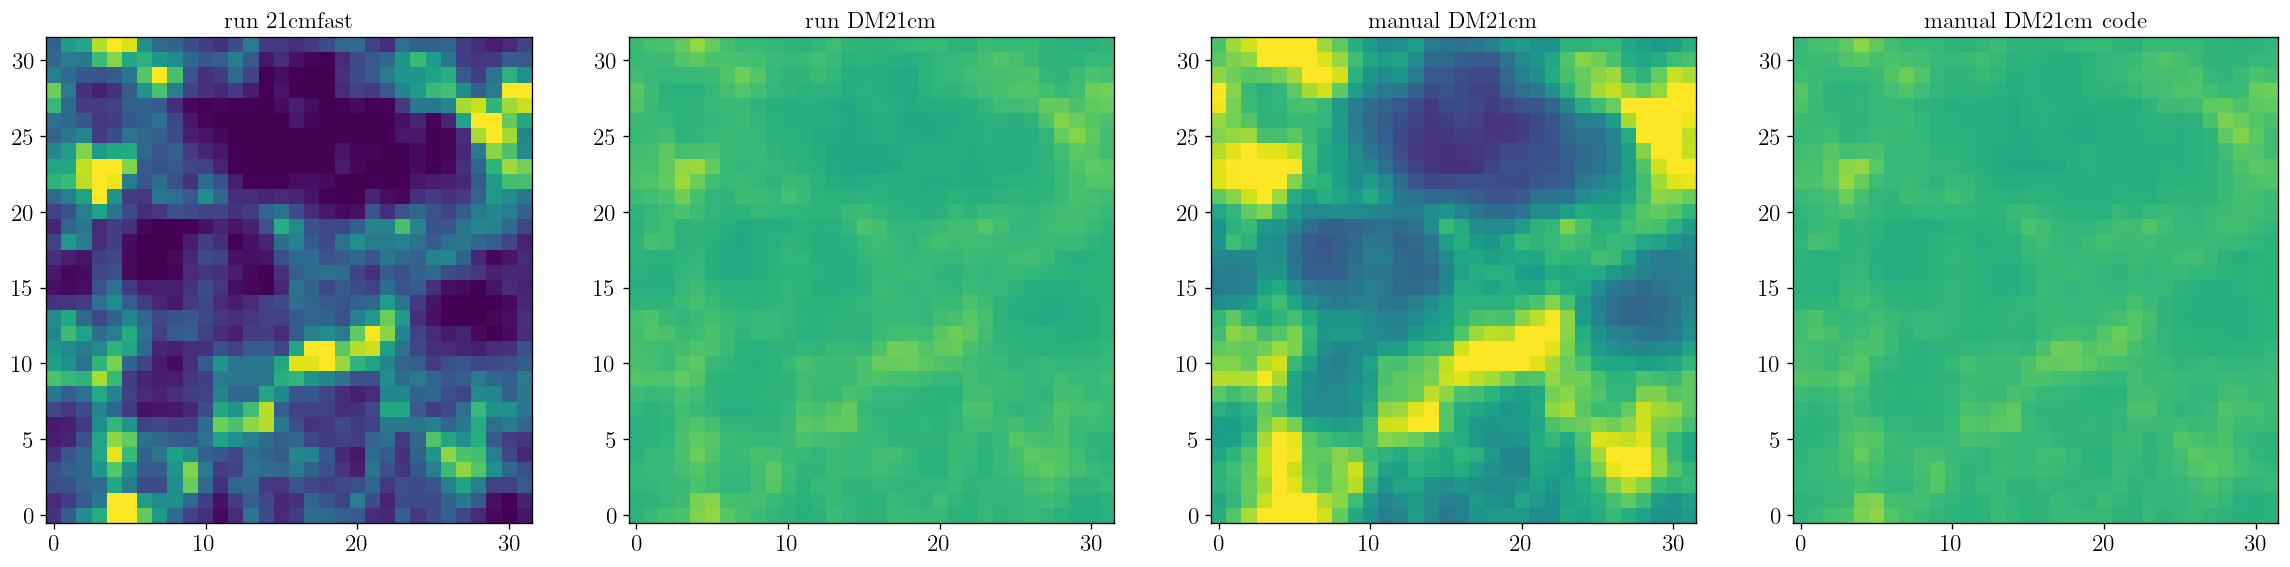

In [104]:
z4 = input_ionization.input_ionization[0]
z3 = dep_ion_box[0] / np.mean(dep_ion_box) * ref_interp(z_current) / phys.rydberg
z2 = dxe_dc
z1 = dxe_pc
vmin = np.quantile(np.concatenate([z1, z2, z3, z4]), 0.02)
vmax = np.quantile(np.concatenate([z1, z2, z3, z4]), 0.98)

fig, axs = plt.subplots(1, 4, figsize=(24, 6))
axs[0].imshow(z1, origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
axs[1].imshow(z2, origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
axs[2].imshow(z3, origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
axs[3].imshow(z4, origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
for i, title in enumerate(['run 21cmfast', 'run DM21cm', 'manual DM21cm', 'manual DM21cm code']):
    axs[i].set_title(title)
#plt.imshow(z, origin='lower', cmap='viridis')
print(np.std(z1)/np.mean(z1), np.mean(z1))
print(np.std(z2)/np.mean(z2), np.mean(z2))
print(np.std(z3)/np.mean(z3), np.mean(z3))
print(np.std(z4)/np.mean(z4), np.mean(z4))

In [94]:
ref_interp(z_current) / phys.rydberg

0.0009005296843938018

0.02904818442762725 0.0008940225736892948
0.006156514 0.00089956215
0.04292873 0.0008457381


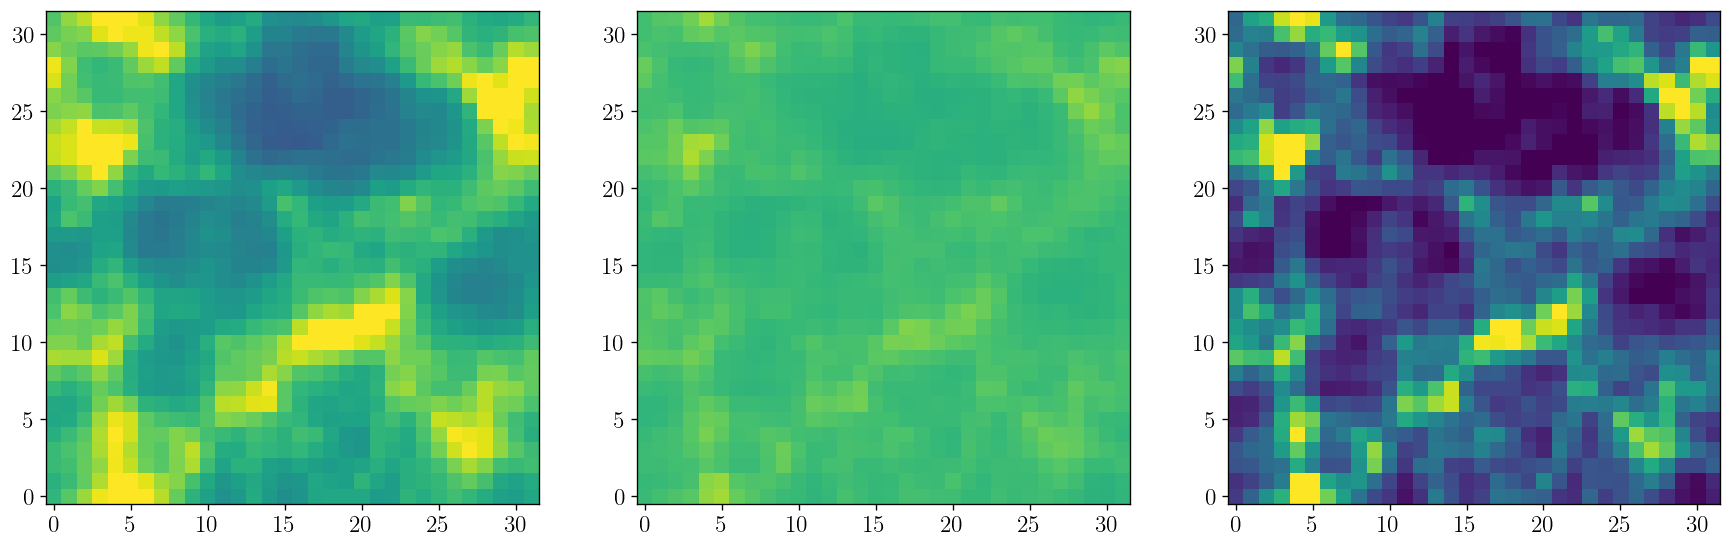

In [ ]:
z = input_ionization.input_ionization[0]
z2 = dxe_dc
z3 = dxe_pc
vmin = np.quantile(np.concatenate([z, z2, z3]), 0.02)
vmax = np.quantile(np.concatenate([z, z2, z3]), 0.98)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(z, origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
axs[1].imshow(z2, origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
axs[2].imshow(z3, origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
#plt.imshow(z, origin='lower', cmap='viridis')
print(np.std(z)/np.mean(z), np.mean(z))
print(np.std(z2)/np.mean(z2), np.mean(z2))
print(np.std(z3)/np.mean(z3), np.mean(z3))

In [78]:
z_next

5.0

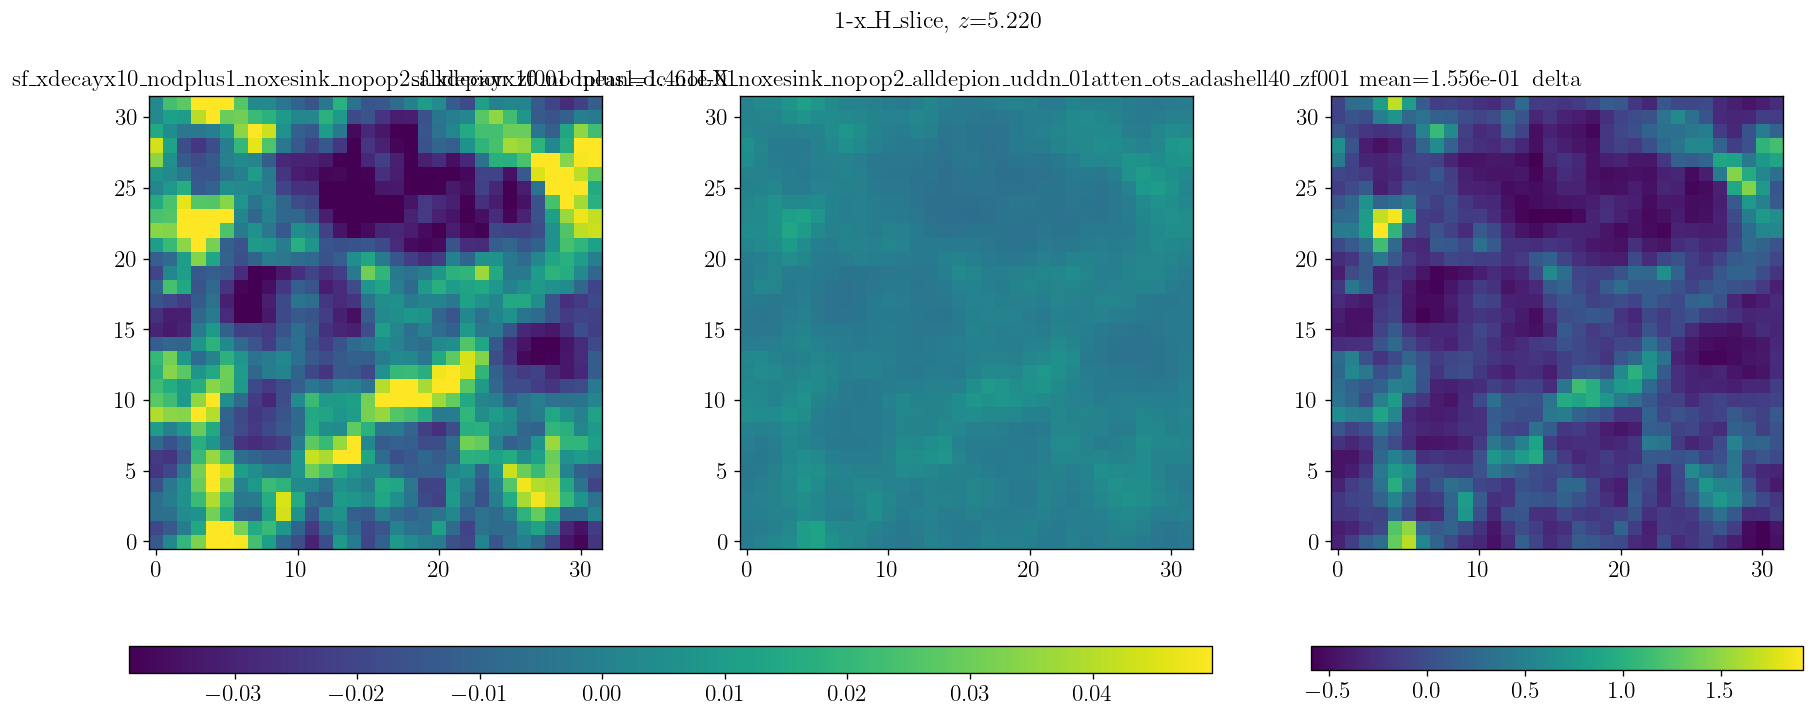

In [48]:
plot_silces_multi_runs(r_s, [2000, 2000], 'x_H_slice', titles=titles, plot_delta=True, shift_mean=False, individual_cbar=False)

## 2. Shell contribution

In [10]:
sys.path.append("..")
import dm21cm.physics as phys
import py21cmfast as p21c

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


### 2.1 Shell only

In [38]:
def shell_dc(rec, i, dlogR=False):

    r_out = rec['dep_tracker'][i]['R_shells']
    if dlogR:
        #r = np.append(r_out, 0.)
        r = np.insert(r_out, 0, 2*r_out[0] - r_out[1])
        #r_diff = np.log10((r[1:] + r[:-1]) / 2)
        r_diff = np.log10(r)
    else:
        #r_diff = np.append(r_out, 0.)
        r_diff = np.insert(r_out, 0, 2*r_out[0] - r_out[1])
    x = rec['1-x_H'][i]
    #norm = 2 / (3*phys.kB*(1+x)) / phys.A_per_B
    norm = 1 / 13.6 / phys.A_per_B
    dep_heat = rec['dep_tracker'][i]['dep_ion_shells'] # [eV]
    return r_out, norm*dep_heat / np.abs(np.diff(r_diff)) # [Mpc or log10Mpc], [K/Mpc or log10Mpc]

def r_vals_pc(BOX_LEN=64, HII_DIM=32, Rmax=p21c.global_params.R_XLy_MAX, n=p21c.global_params.NUM_FILTER_STEPS_FOR_Ts):
    L_FACTOR = 0.620350491
    R = L_FACTOR * BOX_LEN/HII_DIM
    R_factor = pow(Rmax/R, 1/n)
    r_vals = R * R_factor ** np.arange(n)
    return r_vals

def shell_pc(rec, i, dlogR=False, multiplier=1., **kwargs):
    
    r_out = r_vals_pc(**kwargs)
    if dlogR:
        r = np.insert(r_out, 0, 0.)
        r = np.append(r, 2*r[-1] - r[-2])
        r_diff = np.log10((r[1:] + r[:-1]) / 2)
    else:
        r_diff = np.insert(r_out, 0, 0.)
    dep_heat_K = rec['pc_shell_dep_info'][i] # [K]
    return r_out, multiplier * dep_heat_K / np.abs(np.diff(r_diff)) # [Mpc or log10Mpc], [K/Mpc or log10Mpc]

/tmp/ipykernel_176091/403784424.py:8: RuntimeWarning: divide by zero encountered in log10
  r_diff = np.log10(r)


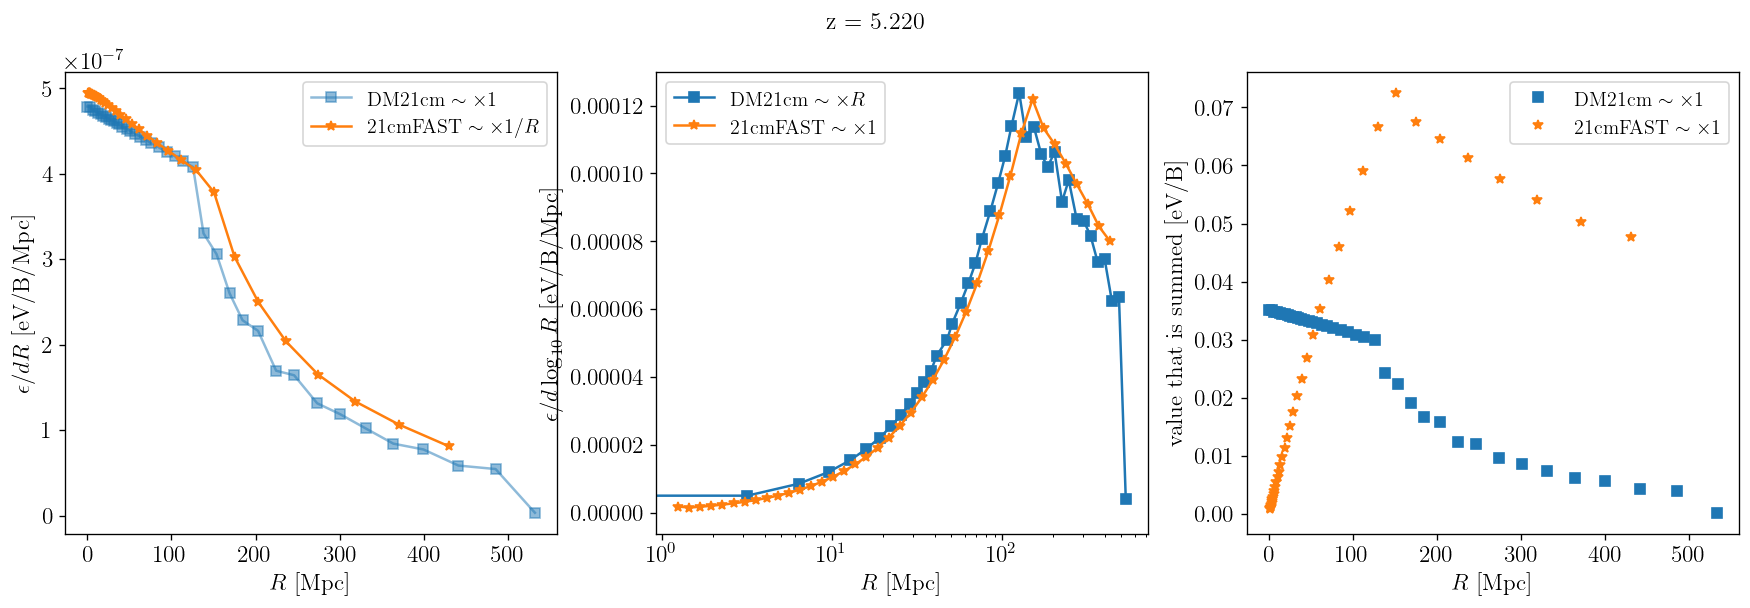

In [46]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

i = 2000

rn_s_dc = [
    'sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_alldepion_uddn_01atten_ots_adashell40_zf001',
]

rn_s_pc = [
    'sf_xdecayx10_nodplus1_noxesink_nopop2_alldepion_zf001',
]

r_s_dc = [get_rec(rn) for rn in rn_s_dc]
r_s_pc = [get_rec(rn) for rn in rn_s_pc]

ax = axs[0]
for rec in r_s_dc:
    ax.plot(*shell_dc(rec, i, dlogR=False), '-s', label=r'DM21cm $\sim\times1$', alpha=0.5)
for rec in r_s_pc:
    ax.plot(*shell_pc(rec, i, dlogR=False), '-*', label=r'21cmFAST $\sim\times1/R$')
ax.set(xlabel=r'$R$ [Mpc]', ylabel=r'$\epsilon/dR$ [eV/B/Mpc]')
ax.legend()

ax = axs[1]
for rec in r_s_dc:
    ax.plot(*shell_dc(rec, i, dlogR=True), '-s', label=r'DM21cm $\sim\times R$')
for rec in r_s_pc:
    ax.plot(*shell_pc(rec, i, dlogR=True), '-*', label=r'21cmFAST $\sim\times1$')
ax.set(xscale='log')
ax.set(xlabel=r'$R$ [Mpc]', ylabel=r'$\epsilon/d\log_{10}R$ [eV/B/Mpc]')
ax.legend()

ax = axs[2]
for r in r_s_dc:
    r_out, val = shell_dc(r, i, dlogR=False)
    val = np.nan_to_num(val, posinf=0., neginf=0.)
    ax.plot(r_out, val/np.sum(val), 's', label=r'DM21cm $\sim\times 1$')
for r in r_s_pc:
    r_out, val = shell_pc(r, i, dlogR=True)
    val = np.nan_to_num(val, posinf=0., neginf=0.)
    ax.plot(r_out, val/np.sum(val), '*', label=r'21cmFAST $\sim\times 1$')
#ax.set(yscale='log')
ax.set(xlabel=r'$R$ [Mpc]', ylabel=r'value that is summed [eV/B]')
ax.legend()

fig.suptitle(f"z = {r_s_dc[0]['z'][i]:.3f}");

In [42]:
for r in r_s_dc:
    r_out, val = shell_dc(r, i, dlogR=False)

/tmp/ipykernel_150724/1879474183.py:14: RuntimeWarning: divide by zero encountered in divide
  return r_out, norm*dep_heat / np.abs(np.diff(r_diff)) # [Mpc or log10Mpc], [K/Mpc or log10Mpc]


In [14]:
r_s_dc[-1]['dep_tracker'][-1]['R_shells']

array([189.28621903, 158.11963895, 126.80142859,  95.33097235,
        63.7076564 ,  31.93086887,   0.        ])

In [50]:
np.nan_to_num(val, posinf=0., neginf=0.)

array([9.36171512e-007, 9.39927089e-007, 9.43683304e-007, 9.47439896e-007,
       9.51196864e-007, 9.54954201e-007, 9.58711886e-007, 9.62469846e-007,
       9.66227924e-007, 9.69985952e-007, 9.73743891e-007, 9.77501756e-007,
       9.81259567e-007, 9.85017169e-007, 9.88773989e-007, 9.92529257e-007,
       9.96281709e-007, 1.00002901e-006, 1.00376666e-006, 1.00748687e-006,
       1.01478279e-006, 1.79769313e+308])

### 2.2 bath vs. shell toteng

In [7]:
from scipy import interpolate
from dm21cm.evolve import get_z_edges
from dm21cm.utils import load_h5_dict
data_dir = os.environ['DM21CM_DATA_DIR'] + '/tf/zf01/data'

In [16]:
sfrd_tables = load_h5_dict(f"{data_dir}/sfrd_tables.h5")
z_range = sfrd_tables['z_range']
st_sfrd_table = sfrd_tables['st_sfrd_table']
ST_SFRD_Interpolator = interpolate.interp1d(z_range, st_sfrd_table * 10.)

In [8]:
rn = 'sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_uddn_01atten_bath_ots'
rec = get_rec(rn)
spec_cache = pickle.load(open(f"{os.environ['P21C_CACHE_DIR']}/{rn}/spec_cache.p", 'rb'))

In [18]:
def get_bath_R_eng(spec_cache, zf):
    bath_eng_s = []
    R_s = []
    z_edges = get_z_edges(45, 5, zf)[1:]
    for i_s in range(len(spec_cache.spectrum_list)):
        z = z_edges[i_s]
        bath_eng_s.append(spec_cache.spectrum_list[i_s].toteng() * ST_SFRD_Interpolator(z))
        R_s.append(phys.conformal_dx_between_z(z, z_edges[-1]))
    bath_eng_s = np.array(bath_eng_s)
    R_s = np.array(R_s)
    return R_s, bath_eng_s

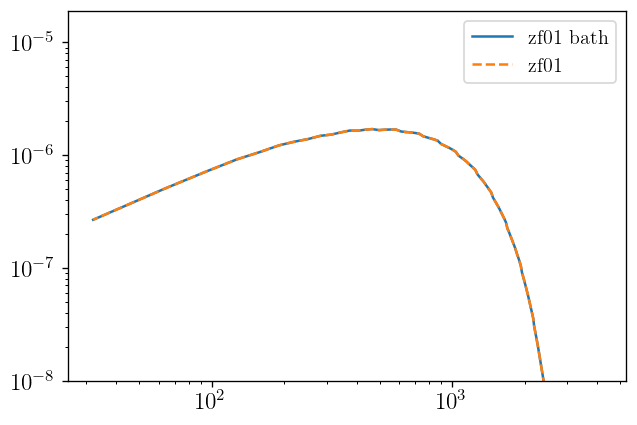

In [23]:
rn = 'sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_uddn_01atten_bath_ots'
spec_cache = pickle.load(open(f"{os.environ['P21C_CACHE_DIR']}/{rn}/spec_cache.p", 'rb'))
R_s, eng_s = get_bath_R_eng(spec_cache, 1.01)
plt.plot(R_s, R_s*eng_s, label='zf01 bath')

rn = 'sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_uddn_01atten_ots'
spec_cache = pickle.load(open(f"{os.environ['P21C_CACHE_DIR']}/{rn}/spec_cache.p", 'rb'))
R_s, eng_s = get_bath_R_eng(spec_cache, 1.01)
plt.plot(R_s, R_s*eng_s, label='zf01', ls='--')

plt.loglog()
plt.ylim(1e-8, None)
plt.legend()

### 2.3 shell + bath

In [21]:
rec = get_rec('sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_uddn_01atten_bath_ots')
rec_shell = get_rec('sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_uddn_01atten_ots')
spec_cache_shell = pickle.load(open(os.environ['P21C_CACHE_DIR'] + '/sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_uddn_01atten_ots/spec_cache.p', 'rb'))

In [8]:
z_edges = get_z_edges(45, 5, 1.01)[1:]

In [9]:
rec['dep_tracker'][-1].keys()

dict_keys(['dep_ion_bath', 'dep_heat_bath', 'dep_ion_shells', 'dep_heat_shells', 'R_shells', 'bath_toteng_arr'])

In [10]:

dtr['R_shells']

array([126.80142859,  95.33097235,  63.7076564 ,  31.93086887,
         0.        ])

In [14]:
len(rec_shell['dep_tracker'][-1])['dep_ion_shells']

19

In [29]:
dtr = rec['dep_tracker'][-1]
dtr_shell = rec_shell['dep_tracker'][-1]

dep_ion_arr = []
photeng_arr = []
R_arr = []
for i_sh in range(19):
    i = 204 - len(dtr_shell['R_shells']) + i_sh
    z = z_edges[i]
    R = phys.conformal_dx_between_z(z, z_edges[-1])
    dep_ion_arr.append(dtr_shell['dep_ion_shells'][i_sh])
    photeng_arr.append(spec_cache_shell.spectrum_list[i].toteng())
    R_arr.append(R)
    print(f"i={i} z={z:.3f} R={R:.2f} R_shells={dtr_shell['R_shells'][i_sh]:.2f} dep_ion={dtr_shell['dep_ion_shells'][i_sh]:.3e} photeng={spec_cache_shell.spectrum_list[i].toteng():.3e}")
dep_ion_arr = np.array(dep_ion_arr)
photeng_arr = np.array(photeng_arr)
R_arr = np.array(R_arr)

i=185 z=6.249 R=583.77 R_shells=551.68 dep_ion=8.656e-05 photeng=2.778e-01
i=186 z=6.177 R=554.37 R_shells=522.29 dep_ion=9.091e-05 photeng=2.817e-01
i=187 z=6.106 R=524.83 R_shells=492.75 dep_ion=9.529e-05 photeng=2.857e-01
i=188 z=6.035 R=495.15 R_shells=463.06 dep_ion=1.283e-04 photeng=2.897e-01
i=189 z=5.966 R=465.32 R_shells=433.23 dep_ion=1.345e-04 photeng=3.032e-01
i=190 z=5.897 R=435.34 R_shells=403.26 dep_ion=1.414e-04 photeng=3.074e-01
i=191 z=5.829 R=405.22 R_shells=373.14 dep_ion=1.909e-04 photeng=3.117e-01
i=192 z=5.761 R=374.95 R_shells=342.87 dep_ion=1.999e-04 photeng=3.258e-01
i=193 z=5.694 R=344.53 R_shells=312.45 dep_ion=2.091e-04 photeng=3.303e-01
i=194 z=5.628 R=313.97 R_shells=281.88 dep_ion=2.812e-04 photeng=3.348e-01
i=195 z=5.562 R=283.25 R_shells=251.17 dep_ion=2.944e-04 photeng=3.494e-01
i=196 z=5.497 R=252.39 R_shells=220.30 dep_ion=3.980e-04 photeng=3.542e-01
i=197 z=5.433 R=221.37 R_shells=189.29 dep_ion=4.166e-04 photeng=3.692e-01
i=198 z=5.369 R=190.21 R_

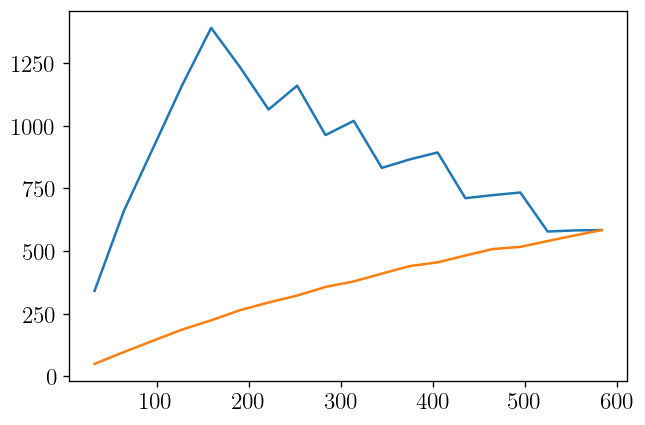

In [30]:
plt.plot(R_arr, R_arr*dep_ion_arr/dep_ion_arr[0])
plt.plot(R_arr, R_arr*photeng_arr/photeng_arr[0])

/tmp/ipykernel_90504/3562442082.py:12: RuntimeWarning: divide by zero encountered in log10
  ax.plot(r[:-1], v[:-1] / np.diff(np.log10(r)), '-o')


[Text(0.5, 0, 'R [Mpc]'), Text(0, 0.5, 'dep heat/dlogR [eV/s]'), None]

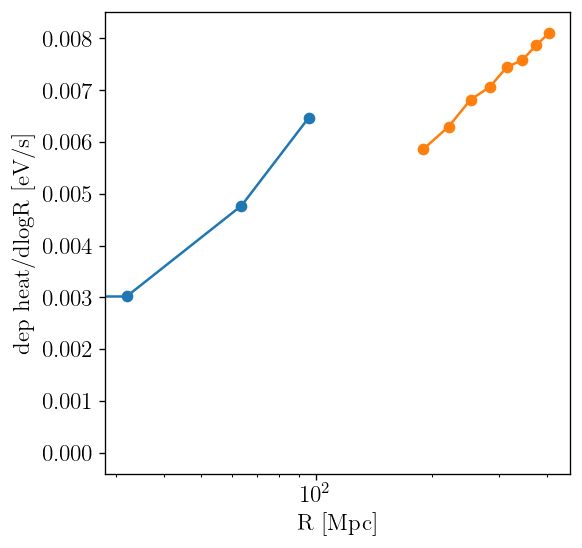

In [84]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
ax = axs

dtr = rec['dep_tracker'][-1]

i_bath_start = len(z_edges) - len(dtr['R_shells']) - len(dtr['bath_toteng_arr'])
i_bath_end = len(z_edges) - len(dtr['R_shells'])
bath_R_s = np.array([phys.conformal_dx_between_z(z_edges[i-1], z_edges[-1]) for i in range(i_bath_start, i_bath_end)])

r = dtr['R_shells'][::-1]
v = dtr['dep_ion_shells'][::-1]
ax.plot(r[:-1], v[:-1] / np.diff(np.log10(r)), '-o')

r = bath_R_s[::-1]
v = dtr['dep_ion_bath'] * np.array(dtr['bath_toteng_arr'])/np.sum(dtr['bath_toteng_arr'])
v = v[::-1]
ax.plot(r[:-1], v[:-1] / np.diff(np.log10(r)), '-o')

ax.set(xlabel='R [Mpc]', ylabel='dep heat/dlogR [eV/s]', xscale='log')

In [17]:
spec_cache = pickle.load(open('../outputs/dm21cm/sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_uddn_01atten_bath_ots_zf001_spec_cache.p', 'rb'))

In [24]:
spec_cache.spectrum_list[0].approx_attentuation_arr_repr

'00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111'

### bath overestimated

In [37]:
from dm21cm.utils import load_h5_dict
from darkhistory.spec.spectrum import Spectrum

In [36]:
abscs = load_h5_dict(os.environ['DM21CM_DATA_DIR']+'/tf/zf01/data/abscissas.h5')

In [45]:
def init_spec():
    ilo = np.searchsorted(abscs['photE'], 500.)
    ihi = np.searchsorted(abscs['photE'], 10000.)
    dNdE = abscs['photE']**-2
    dNdE[:ilo] *= 0.
    dNdE[ihi:] *= 0.
    s = Spectrum(abscs['photE'], dNdE, spec_type='dNdE', rs=1+45.)
    s.switch_spec_type('N')
    return s

def cont_redshift(s, z_edges, i):
    for z in z_edges[:i+1]:
        s.redshift(z)

def bath_overestimate(rec, i_z_view, i_bath):
    dtr = rec['dep_tracker'][i_z_view]
    i_z = len(z_edges) - len(dtr['R_shells']) - len(dtr['bath_toteng_arr']) + i_bath
    scont = init_spec()
    sinst = init_spec()
    cont_redshift(scont, z_edges, i_z)
    sinst.redshift(z_edges[i_z])

    ilo = np.searchsorted(abscs['photE'], 500.)
    scont.N[:ilo] *= 0.
    sinst.N[:ilo] *= 0.

    s = spec_cache.spectrum_list[i_bath]
    atten_arr = s.approx_attenuation_arr
    cont_eng = np.dot(s.eng, scont.N*atten_arr)
    inst_eng = np.dot(s.eng, sinst.N*atten_arr)
    return inst_eng/cont_eng

In [60]:
spec_cache01 = pickle.load(open(os.environ['P21C_CACHE_DIR'] + '/sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_uddn_01atten_bath_ots/spec_cache.p', 'rb'))

In [54]:
bath_eng_naive = []
R_s = []
i_z_view = -1
dtr = rec['dep_tracker'][i_z_view]

for i_bath_rel in range(len(dtr['bath_toteng_arr'])):
    i_z = len(z_edges) - len(dtr['R_shells']) - len(dtr['bath_toteng_arr']) + i_bath_rel
    bath_eng_naive.append(spec_cache.spectrum_list[i_z].toteng())
    R_s.append(phys.conformal_dx_between_z(z_edges[i_z], z_edges[-1]))
bath_eng_naive = np.array(bath_eng_naive)
R_s = np.array(R_s)

In [63]:
len(spec_cache01.spectrum_list)

204

In [59]:
np.diff(R_s)

array([-3.02265529, -3.02413723, -3.0256198 , -3.02710301, -3.02858684,
       -3.03007131, -3.03155641, -3.03304215, -3.03452852, -3.03601552,
       -3.03750315, -3.03899141, -3.04048031, -3.04196984, -3.04346   ,
       -3.04495079, -3.04644221, -3.04793427, -3.04942696, -3.05092027,
       -3.05241423, -3.05390881, -3.05540402, -3.05689987, -3.05839634,
       -3.05989345, -3.06139119, -3.06288956, -3.06438856, -3.06588819,
       -3.06738846, -3.06888935, -3.07039087, -3.07189303, -3.07339581,
       -3.07489923, -3.07640327, -3.07790795, -3.07941326, -3.08091919,
       -3.08242576, -3.08393295, -3.08544078, -3.08694923, -3.08845831,
       -3.08996803, -3.09147837, -3.09298934, -3.09450094, -3.09601317,
       -3.09752603, -3.09903951, -3.10055363, -3.10206837, -3.10358374,
       -3.10509974, -3.10661637, -3.10813362, -3.10965151, -3.11117002,
       -3.11268915, -3.11420892, -3.11572931, -3.11725033, -3.11877198,
       -3.12029425, -3.12181715, -3.12334067, -3.12486483, -3.12

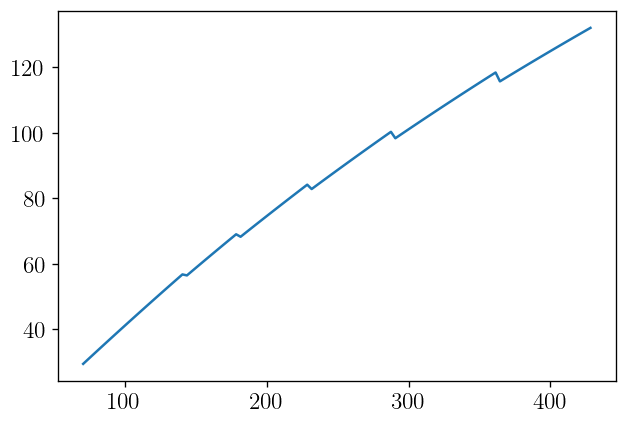

In [57]:
plt.plot(R_s, R_s*np.array(bath_eng_naive))

In [ ]:
i_z_view = -1
dtr = rec['dep_tracker'][i_z_view]
for i_bath_rel in range(len(dtr['bath_toteng_arr'])):
    print(i_bath_rel, bath_overestimate(rec, i_z_view, i_bath_rel))

(1e-10, 0.0001)

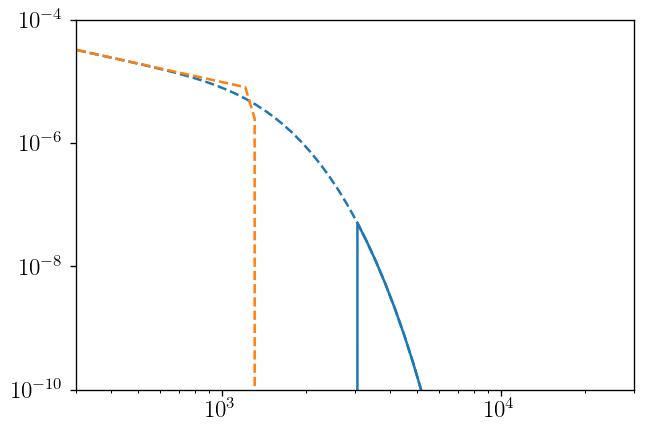

In [44]:
i_z_view = -1
i_sl = 0

dtr = rec['dep_tracker'][i_z_view]
i_z = len(z_edges) - len(dtr['R_shells']) - len(dtr['bath_toteng_arr']) + i_sl
scont = init_spec()
sinst = init_spec()
cont_redshift(scont, z_edges, i_z)
sinst.redshift(z_edges[i_z])

s = spec_cache.spectrum_list[i_sl]
atten_arr = s.approx_attenuation_arr

plt.plot(s.eng, scont.N, color='C0', ls='--')
plt.plot(s.eng, scont.N*atten_arr, color='C0')
plt.plot(s.eng, sinst.N, color='C1', ls='--')
plt.plot(s.eng, sinst.N*atten_arr, color='C1')
plt.loglog()
plt.xlim(300, 30000)
plt.ylim(1e-10, 1e-4)

[(300.0, 30000.0), None]

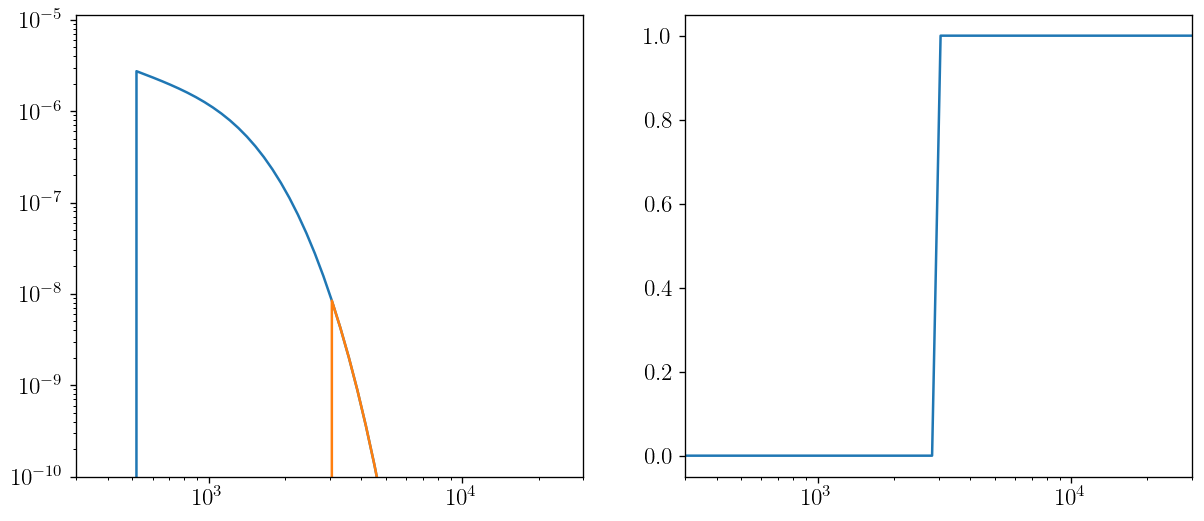

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ax = axs[0]

s = spec_cache.spectrum_list[0]
ax.plot(s.eng, s.spectrum.N)
ax.plot(s.eng, s.N)
ax.set(xlim=(300, 30000), xscale='log', yscale='log', ylim=(1e-10, None))

ax = axs[1]
ax.plot(s.eng, s.approx_attenuation_arr)
ax.set(xlim=(300, 30000), xscale='log')

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
ax = axs

dtr = r['dep_tracker'][1300]
ax.plot(dtr['R_shells'], dtr['dep_heat_shells'], '-s')
ax.set(xlabel='R [Mpc]', ylabel='dep heat/dlogR [eV/s]')

ax.plot(bath_R_s, dtr['dep_heat_bath']*np.array(dtr['bath_toteng_arr'])/np.sum(dtr['bath_toteng_arr']), '-s')

In [ ]:
rn = 'sf_xdecayx100_nodplus1_dc_noLX_nopop2_uddn'
r = np.load(f"../outputs/dm21cm/{rn}_records.npy", allow_pickle=True).item()
shellinfo = r['shell_dep_info'][-1]
x_e_mean = r['x_e'][-1]

In [ ]:
rn2 = 'sf_xdecayx100_nodplus1_dc_noLX_nopop2_uddn_xrayots_cut500_zf001'
r2 = np.load(f"../outputs/dm21cm/{rn2}_records.npy", allow_pickle=True).item()
shellinfo2 = r2['shell_dep_info'][-1]
x_e_mean2 = r2['x_e'][-1]

In [ ]:
rnpc = 'sf_xdecayx100_nodplus1_nopop2'
si = pickle.load(open(f"../outputs/dm21cm/{rnpc}_shellinfo.p", 'rb'))
si_mean = np.mean(si, axis=(1, 2, 3))

In [53]:
sys.path.append("..")
import dm21cm.physics as phys
import py21cmfast as p21c

In [ ]:
plt.plot(si_mean, '*', color='C1')
plt.ylabel("dT")
plt.xlabel("shell number")

In [ ]:
global_params = p21c.global_params

L_FACTOR = 0.620350491
BOX_LEN = 64
HII_DIM = 32
R = L_FACTOR* BOX_LEN/HII_DIM
R_factor = pow(global_params.R_XLy_MAX/R, 1/global_params.NUM_FILTER_STEPS_FOR_Ts)

r_vals = R*R_factor**np.arange(40)

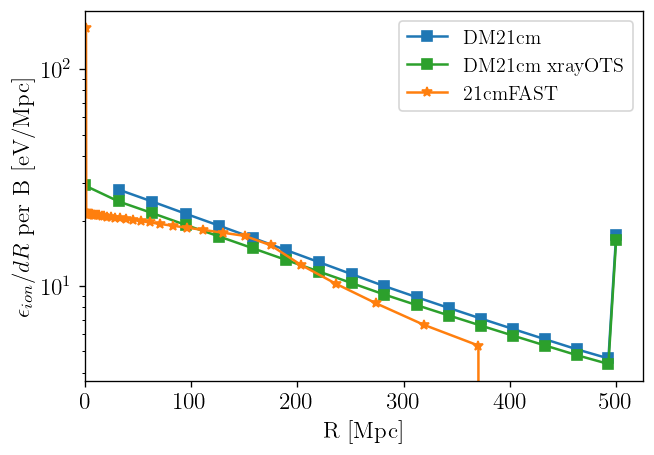

In [ ]:
R_DC = np.concatenate([shellinfo['R2'], np.array([0.])])
norm = 2 / (3*phys.kB*(1+x_e_mean)) / phys.A_per_B
plt.plot(R_DC[:-1], norm*shellinfo['heat']/np.abs(np.diff(R_DC)), '-s', color='C0', label='DM21cm')

R_DC2 = np.concatenate([shellinfo2['R2'], np.array([-31.])])
norm2 = 2 / (3*phys.kB*(1+x_e_mean2)) / phys.A_per_B
plt.plot(R_DC2[:-1], norm2*shellinfo2['heat']/np.abs(np.diff(R_DC2)), '-s', color='C2', label='DM21cm xrayOTS')

R_PC = np.concatenate([r_vals, np.array([0.])])
plt.plot(R_PC[:-1], si_mean/np.diff(R_PC), '-*', color='C1', label='21cmFAST')
plt.xlim(0, None)
plt.yscale('log')
plt.xlabel('R [Mpc]')
plt.ylabel(r'$\epsilon_{ion}/dR$ per B [eV/Mpc]')
plt.legend()

## GIF

In [17]:
i_array = list(range(0, 200, 10)) + list(range(195, 204))
print(i_array)

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 195, 196, 197, 198, 199, 200, 201, 202, 203]


In [25]:
for i in tqdm(i_array):
    plot_silces_multi_runs(
        r_s, [i, 10*i], 'T_k_slice',
        titles=titles, plot_delta=True, plot_log=False, plot_change_i_s=[1, 10],
        save_fn=f"plots/slices/tmp/{i}.png"#, shift_mean='+'
    )

  0%|          | 0/29 [00:00<?, ?it/s]

100%|██████████| 29/29 [02:06<00:00,  4.38s/it]


In [19]:
from PIL import Image

def create_gif_from_filelist(file_list, output_gif_path, interval_time):
    images = [Image.open(file_path) for file_path in file_list]
    images[0].save(output_gif_path, save_all=True, append_images=images[1:], duration=interval_time * 1000, loop=0)

In [26]:
flist = []
for i in i_array:
    flist.append(f"plots/slices/tmp/{i}.png")

create_gif_from_filelist(flist, "Tk.gif", 0.5)

## A1. Global

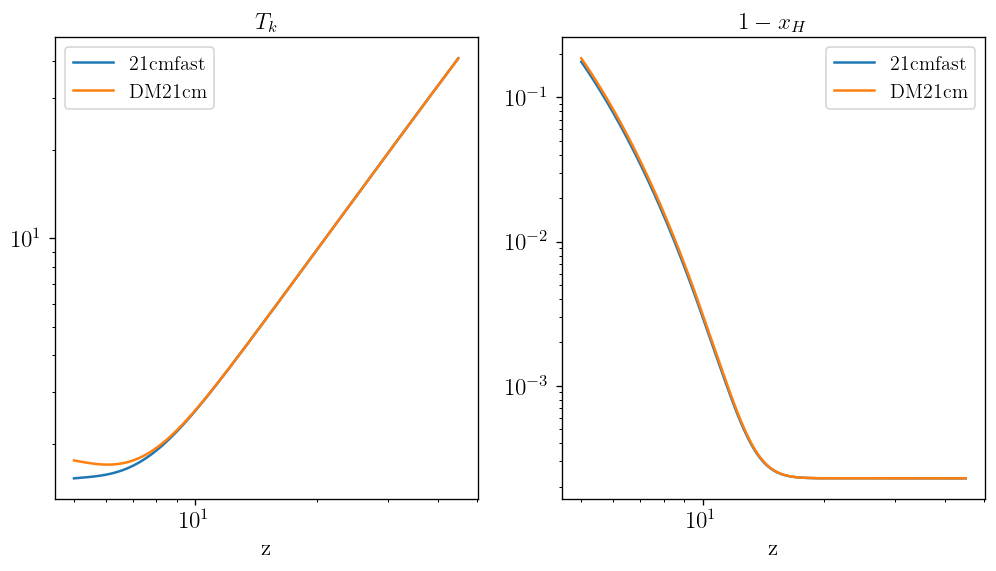

In [27]:
labels=['21cmfast', 'DM21cm']

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

ax = axs[0]
for r, rn in zip(r_s, labels):
    ax.plot(r['z'], r['T_k'], label=rn)
ax.set(title='$T_k$', xlabel='z')
ax.set(xscale='log', yscale='log')
ax.legend()

ax = axs[1]
for r, rn in zip(r_s, labels):
    ax.plot(r['z'], r['1-x_H'], label=rn)
ax.set(title='$1-x_H$', xlabel='z')
ax.set(xscale='log', yscale='log')
ax.legend()

In [16]:
r['T_k'].shape

(2037,)

In [18]:
r['dep_heat']

array([1.11518628e-23, 2.30622855e-23, 3.31978906e-23, ...,
       8.97962162e-03, 9.01368753e-03, 9.03924813e-03])